2025-08-28 17:16:16.887268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded - Train: 9989, Dev: 1109, Test: 2610

Label distribution in training data:
  neutral: 4710
  joy: 1743
  surprise: 1205
  anger: 1109
  sadness: 683
  disgust: 271
  fear: 268
After cleaning - Train: 9989, Dev: 1109, Test: 2610

Preparing sentences for Word2Vec training...
Total sentences for Word2Vec training: 13708

Training Word2Vec model with 128 dimensions...
Word2Vec vocabulary size: 4729
Sample words in vocabulary: ['i', 'you', 'the', 's', 'to', 'a', 'it', 'that', 'and', 't']

Building vocabulary...
Tokenizer vocabulary size: 5364
Final shapes - Train: (9989, 128), Dev: (1109, 128), Test: (2610, 128)

Embedding matrix created:
  Words found in Word2Vec: 2261
  Words not found: 3103
  Coverage: 42.15%
  Sample words not found: ['<OOV>', 'huh', 'dr', 'mr', 'dude', 'ahh', 'yep', 'sweetie', 'sir', 'ugh']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)

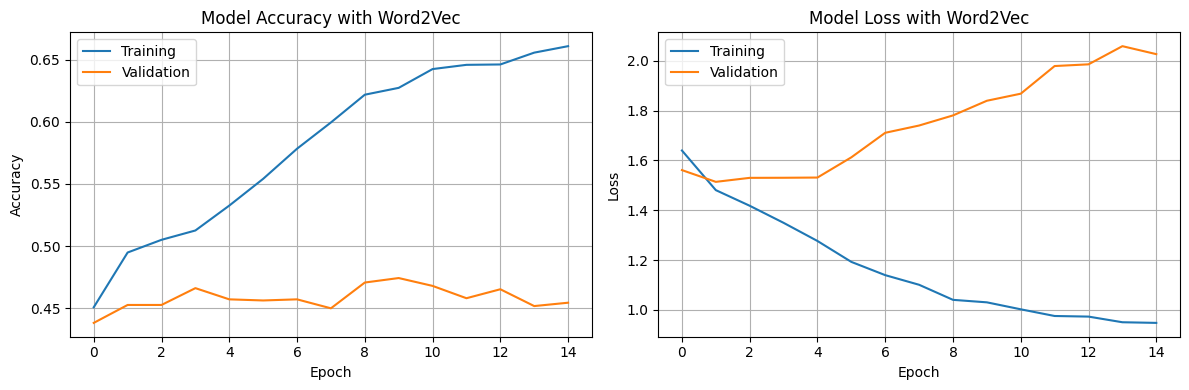


Training completed with Word2Vec embeddings!
Best validation accuracy: 0.4743

SAMPLE PREDICTIONS WITH WORD2VEC

Text: If they cant find a home for her, they kill her! And Im not gonna let that happen to little Yasmine!
True: anger | Predicted: anger | Confidence: 0.291

Text: Whered you get too? We lost you after you opened up all the presents.
True: neutral | Predicted: neutral | Confidence: 0.793

Text: You're flingin'-flangin' right I am!
True: joy | Predicted: neutral | Confidence: 0.335

Text: Oh God, do something.
True: anger | Predicted: neutral | Confidence: 0.236

Text: No-no-no-no-no-no-no-no Its okay, I mean Ilook Rach, I know I scared you off with that whole Naked Thursdays thing, but we dont have to do that!
True: neutral | Predicted: anger | Confidence: 0.258



In [1]:
import os
import pandas as pd
import numpy as np
import re
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from gensim.models import Word2Vec
import multiprocessing

# ---- Paths & labels ----
# Point to the correct directory
DATA_DIR = "/home/jupyter/old_backup"

TRAIN_CSV = os.path.join(DATA_DIR, "train_sent_emo.csv")
DEV_CSV   = os.path.join(DATA_DIR, "dev_sent_emo.csv")
TEST_CSV  = os.path.join(DATA_DIR, "test_sent_emo.csv")

CLASSES = ["anger","disgust","fear","joy","neutral","sadness","surprise"]
label2id = {c: i for i, c in enumerate(CLASSES)}
id2label = {i: c for c, i in label2id.items()}

# ---- Load data ----
def load_meld_data():
    """Load and preprocess MELD dataset"""
    use_cols = ["Utterance", "Emotion"]
    
    try:
        train_df = pd.read_csv(TRAIN_CSV)[use_cols].dropna()
        dev_df   = pd.read_csv(DEV_CSV)[use_cols].dropna()
        test_df  = pd.read_csv(TEST_CSV)[use_cols].dropna()
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Please ensure the MELD CSV files are in the correct directory")
        return None, None, None
    
    # Map emotions to labels
    for name, df in zip(("train", "dev", "test"), (train_df, dev_df, test_df)):
        df["label"] = df["Emotion"].map(label2id)
        df.dropna(subset=["label"], inplace=True)
        df.rename(columns={"Utterance": "text"}, inplace=True)

    print(f"Loaded - Train: {len(train_df)}, Dev: {len(dev_df)}, Test: {len(test_df)}")
    
    # Check label distribution
    print("\nLabel distribution in training data:")
    label_counts = train_df['Emotion'].value_counts()
    for emotion, count in label_counts.items():
        print(f"  {emotion}: {count}")
    
    return train_df, dev_df, test_df

train_df, dev_df, test_df = load_meld_data()

if train_df is None:
    print("Data loading failed. Please check your file paths.")
    exit()

# ---- Text preprocessing ----
def clean_text(text):
    """Clean and normalize text"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    # Keep basic punctuation that might be emotionally relevant
    text = re.sub(r'[^\w\s!?.,]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply preprocessing
train_df["text_clean"] = train_df["text"].apply(clean_text)
dev_df["text_clean"] = dev_df["text"].apply(clean_text)
test_df["text_clean"] = test_df["text"].apply(clean_text)

train_df = train_df[train_df["text_clean"].str.len() > 0]
dev_df = dev_df[dev_df["text_clean"].str.len() > 0]
test_df = test_df[test_df["text_clean"].str.len() > 0]

print(f"After cleaning - Train: {len(train_df)}, Dev: {len(dev_df)}, Test: {len(test_df)}")

# ---- Prepare sentences for Word2Vec ----
def prepare_sentences_for_word2vec(df):
    """Convert text to list of word lists for Word2Vec training"""
    sentences = []
    for text in df["text_clean"]:
        words = text.split()
        if words:  # Only add non-empty sentences
            sentences.append(words)
    return sentences

print("\nPreparing sentences for Word2Vec training...")
# Combine all sentences for Word2Vec training
all_sentences = (prepare_sentences_for_word2vec(train_df) + 
                 prepare_sentences_for_word2vec(dev_df) + 
                 prepare_sentences_for_word2vec(test_df))

print(f"Total sentences for Word2Vec training: {len(all_sentences)}")

# ---- Train Word2Vec model ----
# Word2Vec parameters
EMBEDDING_DIM = 128  # Dimension of word vectors
MIN_WORD_COUNT = 2   # Minimum word frequency
WINDOW_SIZE = 5      # Context window size
NUM_WORKERS = multiprocessing.cpu_count()

print(f"\nTraining Word2Vec model with {EMBEDDING_DIM} dimensions...")
w2v_model = Word2Vec(
    sentences=all_sentences,
    vector_size=EMBEDDING_DIM,
    min_count=MIN_WORD_COUNT,
    window=WINDOW_SIZE,
    workers=NUM_WORKERS,
    sg=1,  # Skip-gram model (0 for CBOW)
    epochs=10,
    seed=42
)

print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")
print(f"Sample words in vocabulary: {list(w2v_model.wv.index_to_key[:10])}")

# ---- Tokenization (aligned with Word2Vec vocabulary) ----
vocab_size = 10000
max_len = 128

tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token="<OOV>",
    lower=True,
    split=' '
)

print("\nBuilding vocabulary...")
tokenizer.fit_on_texts(train_df["text_clean"])

print(f"Tokenizer vocabulary size: {len(tokenizer.word_index)}")

# Convert texts to sequences
X_train = tokenizer.texts_to_sequences(train_df["text_clean"])
X_dev = tokenizer.texts_to_sequences(dev_df["text_clean"])
X_test = tokenizer.texts_to_sequences(test_df["text_clean"])

# Pad sequences
X_train_pad = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_dev_pad = pad_sequences(X_dev, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

y_train = train_df["label"].values
y_dev = dev_df["label"].values
y_test = test_df["label"].values

print(f"Final shapes - Train: {X_train_pad.shape}, Dev: {X_dev_pad.shape}, Test: {X_test_pad.shape}")

# ---- Create embedding matrix from Word2Vec ----
def create_embedding_matrix(word_index, w2v_model, embedding_dim, vocab_size):
    """Create embedding matrix from Word2Vec model"""
    # Initialize matrix with random values for OOV words
    num_words = min(vocab_size, len(word_index) + 1)
    embedding_matrix = np.random.uniform(-0.25, 0.25, (num_words, embedding_dim))
    
    words_found = 0
    words_not_found = []
    
    for word, i in word_index.items():
        if i >= num_words:
            continue
        
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
            words_found += 1
        else:
            words_not_found.append(word)
    
    print(f"\nEmbedding matrix created:")
    print(f"  Words found in Word2Vec: {words_found}")
    print(f"  Words not found: {len(words_not_found)}")
    print(f"  Coverage: {words_found / min(num_words-1, len(word_index)) * 100:.2f}%")
    
    if words_not_found[:10]:
        print(f"  Sample words not found: {words_not_found[:10]}")
    
    return embedding_matrix

# Create embedding matrix
actual_vocab_size = min(vocab_size, len(tokenizer.word_index) + 1)
embedding_matrix = create_embedding_matrix(
    tokenizer.word_index, 
    w2v_model, 
    EMBEDDING_DIM, 
    actual_vocab_size
)

# ---- Model Architecture with Word2Vec embeddings ----
def create_emotion_model_with_word2vec(vocab_size, embedding_matrix, max_len=128, num_classes=7):
    """Create the emotion classification model with pre-trained Word2Vec embeddings"""
    model = Sequential([
        # Embedding layer with pre-trained Word2Vec weights
        Embedding(
            input_dim=vocab_size,
            output_dim=EMBEDDING_DIM,
            input_length=max_len,
            weights=[embedding_matrix],
            trainable=True,  # Allow fine-tuning of embeddings
            mask_zero=True
        ),
        
        # Bidirectional LSTM layers
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
        Bidirectional(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model with Word2Vec embeddings
model = create_emotion_model_with_word2vec(
    vocab_size=actual_vocab_size,
    embedding_matrix=embedding_matrix,
    max_len=max_len,
    num_classes=len(CLASSES)
)

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ---- Training callbacks ----
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# ---- Train model ----
print("\nStarting training with Word2Vec embeddings...")
history = model.fit(
    X_train_pad, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_dev_pad, y_dev),
    callbacks=callbacks,
    verbose=1
)

# ---- Evaluation ----
print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred = model.predict(X_test_pad, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# ---- Classification Report (Manual Implementation) ----
def classification_report_manual(y_true, y_pred, class_names):
    """Manual classification report to avoid sklearn dependency"""
    
    # Calculate metrics for each class
    report = {}
    
    for i, class_name in enumerate(class_names):
        # True positives, false positives, false negatives
        tp = np.sum((y_true == i) & (y_pred == i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))
        
        # Calculate precision, recall, f1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        support = np.sum(y_true == i)
        
        report[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'support': support
        }
    
    return report

# Generate manual classification report
report = classification_report_manual(y_test, y_pred_classes, CLASSES)

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
print("-" * 60)

for class_name, metrics in report.items():
    print(f"{class_name:<12} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} "
          f"{metrics['f1-score']:<10.4f} {metrics['support']:<8}")

# Overall accuracy
overall_accuracy = np.mean(y_test == y_pred_classes)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# ---- Analyze Word2Vec embeddings ----
def analyze_word2vec_embeddings(w2v_model, sample_words=None):
    """Analyze and demonstrate Word2Vec embeddings"""
    print("\n" + "="*60)
    print("WORD2VEC EMBEDDINGS ANALYSIS")
    print("="*60)
    
    # Use emotion-related words if no sample provided
    if sample_words is None:
        sample_words = ['happy', 'sad', 'angry', 'love', 'hate', 'fear', 'surprise', 'good', 'bad']
    
    # Find available words
    available_words = [w for w in sample_words if w in w2v_model.wv]
    
    if available_words:
        print("\nMost similar words:")
        for word in available_words[:3]:  # Show for first 3 available words
            print(f"\n'{word}':")
            similar_words = w2v_model.wv.most_similar(word, topn=5)
            for similar_word, score in similar_words:
                print(f"  - {similar_word}: {score:.3f}")
    
    # Calculate similarity between emotion pairs
    emotion_pairs = [
        ('happy', 'joy'),
        ('sad', 'sadness'),
        ('angry', 'anger'),
        ('love', 'hate'),
        ('good', 'bad')
    ]
    
    print("\n" + "-"*40)
    print("Similarity between word pairs:")
    for word1, word2 in emotion_pairs:
        if word1 in w2v_model.wv and word2 in w2v_model.wv:
            similarity = w2v_model.wv.similarity(word1, word2)
            print(f"  '{word1}' <-> '{word2}': {similarity:.3f}")

# Analyze Word2Vec embeddings
analyze_word2vec_embeddings(w2v_model)

# ---- Plot training history ----
def plot_history(history):
    """Plot training history"""
    try:
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Accuracy plot
        ax1.plot(history.history['accuracy'], label='Training')
        ax1.plot(history.history['val_accuracy'], label='Validation')
        ax1.set_title('Model Accuracy with Word2Vec')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Loss plot
        ax2.plot(history.history['loss'], label='Training')
        ax2.plot(history.history['val_loss'], label='Validation')
        ax2.set_title('Model Loss with Word2Vec')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Matplotlib not available - skipping plots")

plot_history(history)

print(f"\nTraining completed with Word2Vec embeddings!")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

# ---- Sample predictions ----
print("\n" + "="*60)
print("SAMPLE PREDICTIONS WITH WORD2VEC")
print("="*60)

# Show a few test examples
sample_indices = np.random.choice(len(test_df), min(5, len(test_df)), replace=False)

for idx in sample_indices:
    original_idx = test_df.index[idx]
    text = test_df.loc[original_idx, "text"]
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx]
    confidence = np.max(y_pred[idx])
    
    print(f"\nText: {text}")
    print(f"True: {CLASSES[true_label]} | Predicted: {CLASSES[pred_label]} | Confidence: {confidence:.3f}")
    
print("\n" + "="*60)

# ---- Save Word2Vec model (optional) ----
# Uncomment to save the Word2Vec model for later use
# w2v_model.save("meld_word2vec.model")
# print("Word2Vec model saved as 'meld_word2vec.model'")

# ---- Save Keras model (optional) ----
# Uncomment to save the trained emotion classification model
# model.save("meld_emotion_classifier_w2v.h5")
# print("Emotion classifier saved as 'meld_emotion_classifier_w2v.h5'")